# Exploratory Data Analysis (EDA)

Now that I've have completed an initial cleaning of the data, it's time to explore what data I am looking at.
During my EDA, I will explore the missing values and decide on how to deal with that data. I will decide on my dependent variable, and explore its correlation to the features as well as correlations between the different features.

In [1]:
# importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Downloading cvs files
housing = pd.read_csv('../capstone2-housing/rawdata/cleaned_data.csv', index_col=0, parse_dates=['YrMoSold'])
data_dict = pd.read_csv('../capstone2-housing/documents/data_dictionary.csv', index_col=0)

All the rows in the data dictionary that have a value in column "Note" indicate categorical data in this data set. I will use the data dictionary to parse over my data set and change the dtype of those columns to objects. I will also treat columns Id GarageYrBlt, Yearbuilt, and YearRemodAdd as object columns.

In [3]:
# Creating list of columns that should have categorical dtype
dtype_object = ['Id', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']
for index, row in data_dict.iterrows():
    if pd.notnull(row[2]):
        dtype_object.append(row[0])

# Casting correct dtypes for categorical data columns and creating new df for cleaned housing data
housing_dtypes = housing[dtype_object].astype('object')
housing = housing.merge(housing_dtypes).drop_duplicates(keep='first').reset_index(drop=True)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             1460 non-null   object        
 1   MSSubClass     1460 non-null   object        
 2   MSZoning       1460 non-null   object        
 3   LotFrontage    1201 non-null   float64       
 4   LotArea        1460 non-null   int64         
 5   Street         1460 non-null   object        
 6   Alley          91 non-null     object        
 7   LotShape       1460 non-null   object        
 8   LandContour    1460 non-null   object        
 9   Utilities      1460 non-null   object        
 10  LotConfig      1460 non-null   object        
 11  LandSlope      1460 non-null   object        
 12  Neighborhood   1460 non-null   object        
 13  Condition1     1460 non-null   object        
 14  Condition2     1460 non-null   object        
 15  BldgType       1460 n

Now, let's start with deciding on a dependent variable. Since all final closing prices are available, and my goal with this project is to build a model to predict final closing prices, I will start with considering using the column SalePrice as the dependent variable. Let's take a closer look at the column.

In [4]:
housing['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

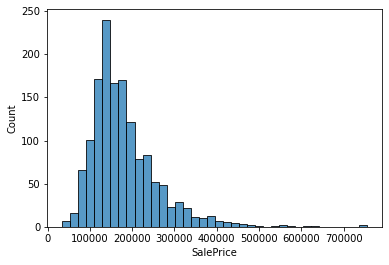

In [5]:
bins = int(np.sqrt(housing['SalePrice'].count()))
_ = sns.histplot(x='SalePrice', data=housing, bins=bins)

Looks like the final SalePrice in Iowa is a continuous value that ranges between 34900 and 755000. Has a mean of 180921.2 and a standard deviation of 79442.5. So I will be moving forward with SalePrice as my dependent variable.  
Have the final sale prices varied a lot over the years?

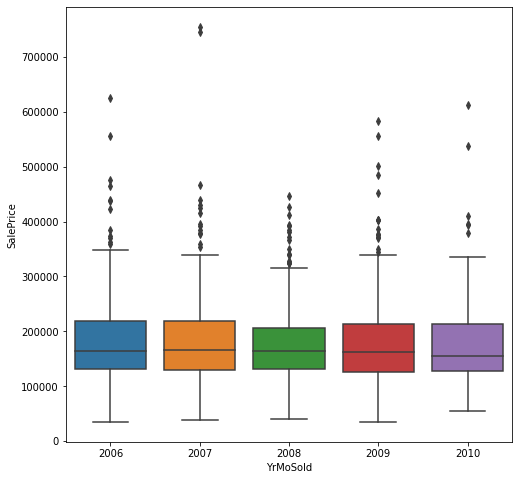

In [6]:
year_sold = housing['YrMoSold'].dt.year
_ = plt.figure(figsize=(8,8))
_ = sns.boxplot(x=year_sold, y='SalePrice', data=housing)

Seems like they have approximately same average value throughout the past year. 
  
So I will be working with sale prices but before we move on let's take a look at the missing values I identified during Data Wrangling and decide what to do with them.

In [7]:
# Count and percentage of missing data in columns
missing = pd.concat([housing.isnull().sum(), 100 * housing.isnull().mean().round(4)], axis=1)
missing.columns=['count_missing', '%_missing']
missing_values = missing.sort_values(by=['count_missing', '%_missing'], ascending=False)
cols_missing = missing_values.loc[missing_values['count_missing'] != 0.00]
cols_missing

,count_missing,%_missing
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55


First, I want to know: what are missing values in this data set? Does NaN mean missing as in incomplete or missing as in property not having the feature. Let's take a look at my data dictionary to see what NaN means for given object dtype columns.

In [8]:
for name in cols_missing.index:
    data_name = data_dict[data_dict['Name'] == name].iloc[0]
    print(data_name['Name'],':', data_name['Notes'], '\n')

PoolQC :        Ex:Excellent       Gd:Good       TA:Average/Typical       Fa:Fair       NA:No Pool 

MiscFeature :        Elev:Elevator       Gar2:2nd Garage (if not described in garage section)       Othr:Other       Shed:Shed (over 100 SF)       TenC:Tennis Court       NA:None 

Alley :        Grvl:Gravel       Pave:Paved       NA :No alley access 

Fence :        GdPrv:Good Privacy       MnPrv:Minimum Privacy       GdWo:Good Wood       MnWw:Minimum Wood/Wire       NA:No Fence 

FireplaceQu :        Ex:Excellent - Exceptional Masonry Fireplace       Gd:Good - Masonry Fireplace in main level       TA:Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement       Fa:Fair - Prefabricated Fireplace in basement       Po:Poor - Ben Franklin Stove       NA:No Fireplace 

LotFrontage : nan 

GarageType :        2Types:More than one type of garage       Attchd:Attached to home       Basment:Basement Garage       BuiltIn:Built-In (Garage part of house - typically 

Looking at the data_dictionary, I can conclude that NaN values in columns with categorical dtypes imply that the property doesn't have that feature. Let's start with changing those missing values to objects 'None': 

In [9]:
Na_cols = cols_missing.T.columns.to_list()
Na_cols.remove('Electrical')
change_to_Na = []
for col in Na_cols:
    if housing[col].dtype == 'object':
        change_to_Na.append(col)
        housing[col] = np.where(housing[col].isnull(), 'Na', housing[col])

In [10]:
# checking new count of missing
missing = pd.concat([housing.isnull().sum(), 100 * housing.isnull().mean().round(4)], axis=1)
missing.columns=['count_missing', '%_missing']
missing_values = missing.sort_values(by=['count_missing', '%_missing'], ascending=False)
cols_missing = missing_values.loc[missing_values['count_missing'] != 0.00]
cols_missing

,count_missing,%_missing
LotFrontage,259,17.74
MasVnrArea,8,0.55
Electrical,1,0.07


Note that I didn't include Electrical in the categorical columns to be changed. Electrical should be existent for all properties (it would be a very expensive fixer-upper if no wiring was present) and the column only has one missing value which means that I'll have to take a closer look at that. 

What is the final sales price and sale condition for the property with the missing value?

In [11]:
housing[['Id','Electrical', 'SaleCondition', 'SalePrice', 'YrMoSold']].loc[housing['Electrical'].isna()]

,Id,Electrical,SaleCondition,SalePrice,YrMoSold
1379,1380,NaN,Normal,167500,2008-05-01


The sale price is 167500 and the condition it was sold under was normal.   
What does the distribution of column Electrical look like?

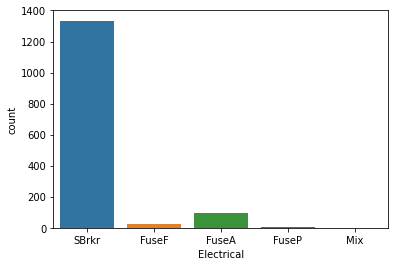

In [12]:
_ = sns.countplot(x='Electrical', data=housing)

In [13]:
housing['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Considering the property being a fairly average property (based on SalePrice and condition) and most common type of Electrical fusing being Standard Circuit Breakers & Romex (SBrkr), I will impute the missing value with SBrkr:

In [14]:
housing['Electrical'] = np.where(housing['Electrical'].isnull(), 'SBrkr', housing['Electrical'])
housing[['Id','Electrical', 'SalePrice']][housing['Id'] == 1380]

,Id,Electrical,SalePrice
1379,1380,SBrkr,167500


That concludes imputation of the categorical variables.   
Now what about the missing values that aren't categorical (GarageYrBlt, LotFrontage and MasVnrArea)?
Let's take a look at them:

In [15]:
housing[['LotFrontage', 'MasVnrArea']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   MasVnrArea   1452 non-null   float64
dtypes: float64(2)
memory usage: 22.9 KB


Starting with MasVnrArea, we have two columns for the Masonry: MasVnrArea, and MasVnrType. Are the missing values of MasVnrArea connected to the None values (indicating 'no Masonry' for that property) in MasVnrType?  

In [16]:
housing[['MasVnrType','MasVnrArea']].loc[housing['MasVnrArea'].isna()]

,MasVnrType,MasVnrArea
234,Na,NaN
529,Na,NaN
650,Na,NaN
936,Na,NaN
973,Na,NaN
977,Na,NaN
1243,Na,NaN
1278,Na,NaN


Based on MasVnrType and MasVnrArea, it's fairly safe to assume that missing values in MasVnrArea means that the properties don't have Masonry veneers. Let's impute missing MasVnrArea values with 0:

In [17]:
housing['MasVnrArea'] = np.where(housing['MasVnrArea'].isnull(), 0.0, housing['MasVnrArea'])

In [18]:
# checking that everything is removed
housing['MasVnrArea'][housing['MasVnrArea'].isnull()]

Series([], Name: MasVnrArea, dtype: float64)

Cool, that is done! Moving on to LotFrontage which currently has 17.74% missing values. Let's take a look at the distribution of LotFrontage:

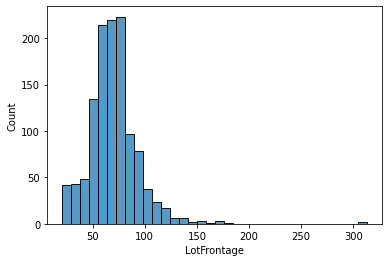

In [19]:
bins = int(np.sqrt(housing['LotFrontage'].count()))
_ = sns.histplot(x='LotFrontage', data=housing, bins=bins)

In [20]:
housing['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

Usually, this sort of data would be best handled by multiple imputation. However, in the interest of time for this project, I will be doing a simple imputation. Since mean and median are only nearly the same and the distribution is skewed, I will impute with the median. 

In [21]:
housing['LotFrontage'] = housing['LotFrontage'].fillna(housing['LotFrontage'].median())
housing['LotFrontage'].describe()

count    1460.000000
mean       69.863699
std        22.027677
min        21.000000
25%        60.000000
50%        69.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

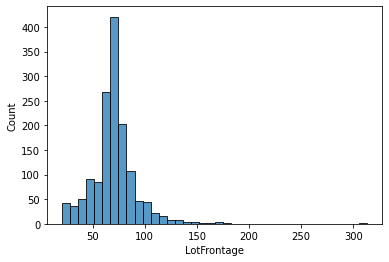

In [22]:
bins = int(np.sqrt(housing['LotFrontage'].count()))
_ = sns.histplot(x='LotFrontage', data=housing, bins=bins)

Following the imputation, the distribution of the LotFrontage data has become slightly more normalized. Let's take a last look at missing values to make sure all of them have been dealt with:

In [23]:
missing = pd.concat([housing.isnull().sum(), 100 * housing.isnull().mean().round(4)], axis=1)
missing.columns=['count_missing', '%_missing']
missing_values = missing.sort_values(by=['count_missing', '%_missing'], ascending=False)
cols_missing = missing_values.loc[missing_values['count_missing'] != 0.00]
cols_missing

,count_missing,%_missing


Perfect! No more missing values.  
To make it easier on processing later, I'm going to convert MasVnrArea and LotFrontage to dtype integers:

In [24]:
housing[['LotFrontage', 'MasVnrArea']] = housing[['LotFrontage', 'MasVnrArea']].astype('int64')
housing[['LotFrontage', 'MasVnrArea']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   LotFrontage  1460 non-null   int64
 1   MasVnrArea   1460 non-null   int64
dtypes: int64(2)
memory usage: 22.9 KB


Now it's time to identify correlations between the features themselves and between my target value (SalePrice) and the features. Let's take a look at the heatmap for the numerical values (I will only display for numerical values due to the high volume of features that are categorical):

In [25]:
#_ = plt.figure(figsize=(18,16))
#_ = sns.heatmap(housing.corr(), annot=True)

Pretty, but incomplete and quite unreadable. Time for some computing!  
I want to find out what can considered a high correlation for this data. Below, I will get dummy variables for the categorical values and compute the pearson correlation coefficients for all variables and extract the upper triangle of the correlation matrix for my dataset.
For the sake of computing, I have decided to drop the Id column below, and to convert the YrMoSold column to a YearSold column treated as a categorical feature.

In [26]:
housing_w_dummies = pd.get_dummies(housing.drop(['Id','YrMoSold'], axis=1))
housing_w_dummies['YearSold'] = housing['YrMoSold'].dt.year.astype(object)
housing_wd_matrix = housing_w_dummies.corr().abs()

In [27]:
# extracting upper triangle of corr matrix
housing_corr_triu = (housing_wd_matrix.where(np.triu(np.ones(housing_wd_matrix.shape), k=1).astype(np.bool)))
triu_values = housing_corr_triu.to_numpy()
triu_values = triu_values[~(np.isnan(triu_values))] 

Now that we have all the correlation coefficients from the upper triangle, I will map the distribution of the correlation coefficients and decide on appropriate thresholds for my data.

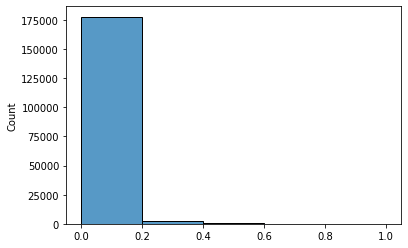

In [28]:
_ = sns.histplot(triu_values, bins=5)

In [29]:
print('min:', np.amin(triu_values), ' ', 'max:', np.amax(triu_values))
print('mean:', np.mean(triu_values), ' ', 'median:', np.median(triu_values))
print('80th quantile:', np.quantile(triu_values, 0.8), ' ', '95th quantile:', np.quantile(triu_values, 0.90))

min: 3.57509252700229e-17   max: 1.0
mean: 0.029138424857317578   median: 0.012677313820927343
80th quantile: 0.03850075707590965   95th quantile: 0.06900774654293529


Pearson Correlation coefficients are considered high when ±0.5 and moderate between ±0.30 and ±0.49. Thus, I will move on with variable pairs of corr coef ±0.5 or higher.  
What are the feature/feature pairs and feature/target pairs that fall in that category?

In [35]:
sol = (housing_wd_matrix.where(np.triu(np.ones(housing_wd_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

In [49]:
feature_pairs = []
feature_target_pairs = []

for index, value in sol.items():
    if value >= 0.4:
        if index[0] == 'SalePrice' or index[1] == 'SalePrice':
            feature_target_pairs.append((index, value))
        else:
            feature_pairs.append((index, value))

print(feature_target_pairs)
print(feature_pairs)

[(('GrLivArea', 'SalePrice'), 0.7086244776126511), (('GarageCars', 'SalePrice'), 0.640409197258349), (('GarageArea', 'SalePrice'), 0.6234314389183598), (('TotalBsmtSF', 'SalePrice'), 0.6135805515591944), (('1stFlrSF', 'SalePrice'), 0.6058521846919166), (('SalePrice', 'ExterQual_TA'), 0.589043523409763), (('FullBath', 'SalePrice'), 0.5606637627484452), (('SalePrice', 'BsmtQual_Ex'), 0.5531048470089422), (('TotRmsAbvGrd', 'SalePrice'), 0.5337231555820238), (('SalePrice', 'KitchenQual_TA'), 0.5192978536548846), (('SalePrice', 'KitchenQual_Ex'), 0.5040936759052956), (('SalePrice', 'Foundation_PConc'), 0.4977337525869438), (('MasVnrArea', 'SalePrice'), 0.47261449900457725), (('SalePrice', 'FireplaceQu_Na'), 0.4719080685164922), (('Fireplaces', 'SalePrice'), 0.4669288367515242), (('SalePrice', 'ExterQual_Gd'), 0.45246612784479223), (('SalePrice', 'BsmtQual_TA'), 0.45239353235010327), (('SalePrice', 'ExterQual_Ex'), 0.45116433022275354), (('SalePrice', 'BsmtFinType1_GLQ'), 0.4345973468827756)